<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [93]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

In [2]:
%run ../../../../../../recidiviz-research/utils/research_utils.py

In [3]:
adjust_plot_scale(0.35)

In [42]:
from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable, TransitionTableType
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
import yaml
%config Completer.use_jedi = False

In [5]:
path_from_state_folder = 'FED/SSA/Fed_SSA_model_inputs.yaml'
display_compartments = ['prison', 'prison_return', 'release']
test_sim = SuperSimulationFactory.build_super_simulation('../state/' + path_from_state_folder)
# test_sim.simulate_baseline(display_compartments)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3888/3888 [00:00<00:00, 8872.82rows/s]
/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/google/cloud/bigquery/table.py:2025: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


outflows_data returned 3888 results


Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 659/659 [00:00<00:00, 1712.65rows/s]


transitions_data returned 659 results


Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1440/1440 [00:00<00:00, 5069.38rows/s]

total_population_data returned 1440 results


841_10yr
Reducing sentences by 11.532372668601548
841_15yr
Reducing sentences by 14.004866192645272
841_5yr
Reducing sentences by 8.541233288429515
courier_960_10yr
Reducing sentences by 2.6170719982473303
courier_960_15yr
Reducing sentences by 2.0709110446711523
courier_960_5yr
Reducing sentences by 2.2164307054775736


/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


initialization time:  63.47789907455444
841_10yr
841_15yr
841_5yr
courier_960_10yr
courier_960_15yr
courier_960_5yr
initialization time:  48.292619943618774
simulation_time:  90.634104013443
simulation_time:  82.65382695198059
72679.35399962208


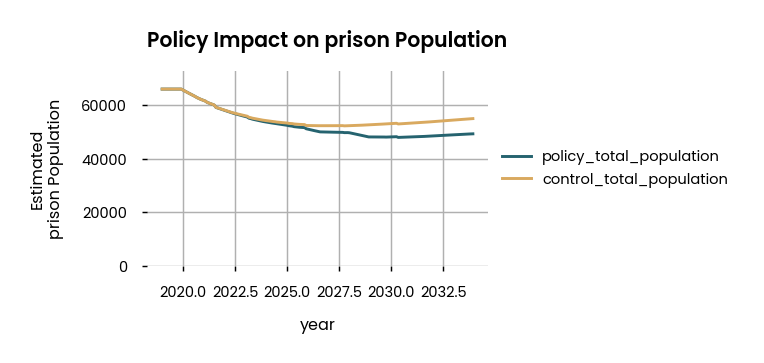

In [81]:
# Policy Option Methods

def reduce_mms(crime_type, retroactive=False):
    return partial(TransitionTable.abolish_mandatory_minimum, 
                   historical_outflows=prison_transitions[prison_transitions.crime_type == crime_type],
                   outflow='release',
                   current_mm='auto',
                   retroactive=retroactive)

policy_list_non_retroactive = [
    SparkPolicy(policy_fn=reduce_mms(crime_type),
                spark_compartment='prison',
                sub_population={'crime_type': crime_type},
                policy_ts=24,
                apply_retroactive=False)
    for crime_type in prison_transitions.crime_type.unique()
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')
add_legend()

In [9]:
test_sim.upload_policy_simulation_results_to_bq('federal_ssa')

{'spending_diff':                         prison release full_release     prison_return
 year                                                                 
 2019.000000                0.0     0.0          0.0               0.0
 2019.083333                0.0     0.0          0.0               0.0
 2019.166667                0.0     0.0          0.0               0.0
 2019.250000                0.0     0.0          0.0               0.0
 2019.333333                0.0     0.0          0.0               0.0
 ...                        ...     ...          ...               ...
 2033.583333  1294549392.190074     0.0          0.0 -104663042.112318
 2033.666667  1312148070.913551     0.0          0.0 -106438377.134856
 2033.750000   1329802817.96349     0.0          0.0 -108217682.398757
 2033.833333  1347516559.159081     0.0          0.0 -109998776.539032
 2033.916667  1365293213.540951     0.0          0.0  -111782031.47958
 
 [180 rows x 4 columns],
 'compartment_life_years_diff':  

In [12]:
%%bigquery total_population
SELECT *
FROM `recidiviz-staging.spark_public_input_data.total_population_data_raw`
WHERE simulation_tag = 'fed_ssa'
AND date_created = '2021-06-07 17:39:05.902867 UTC'
ORDER BY crime_type, compartment, time_step

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1440/1440 [00:01<00:00, 955.68rows/s]


In [21]:
total_population["year"] = test_sim.initializer.time_converter.convert_time_steps_to_year(total_population["time_step"])

In [65]:
total_population[total_population["year"] >= 2019.9]

,simulation_tag,time_step,compartment,total_population,crime,crime_type,age,race,date_created,year
239,fed_ssa,11,prison,41156.585389,None,841_10yr,None,None,2021-06-07 17:39:05.902867+00:00,2019.916667
479,fed_ssa,11,prison,2317.583449,None,841_15yr,None,None,2021-06-07 17:39:05.902867+00:00,2019.916667
719,fed_ssa,11,prison,21668.626084,None,841_5yr,None,None,2021-06-07 17:39:05.902867+00:00,2019.916667
959,fed_ssa,11,prison,793.687088,None,courier_960_10yr,None,None,2021-06-07 17:39:05.902867+00:00,2019.916667
1199,fed_ssa,11,prison,18.141201,None,courier_960_15yr,None,None,2021-06-07 17:39:05.902867+00:00,2019.916667
1439,fed_ssa,11,prison,117.516790,None,courier_960_5yr,None,None,2021-06-07 17:39:05.902867+00:00,2019.916667


Text(0.0, 1.0, 'Prison Population by Crime Type')

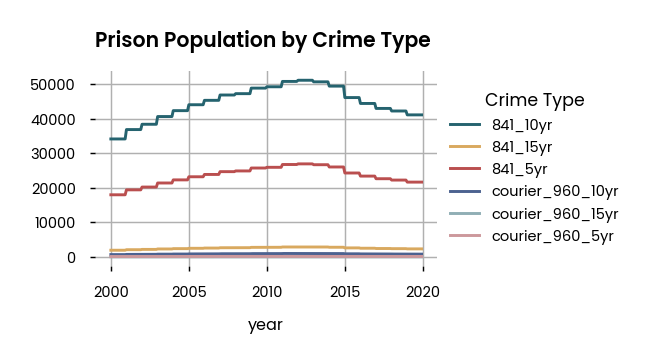

In [22]:
total_population.groupby(["crime_type", "year"]).sum()["total_population"].unstack("crime_type").plot()
add_legend(title="Crime Type")
plt.title("Prison Population by Crime Type")

(0.0, 83548.50499956554)

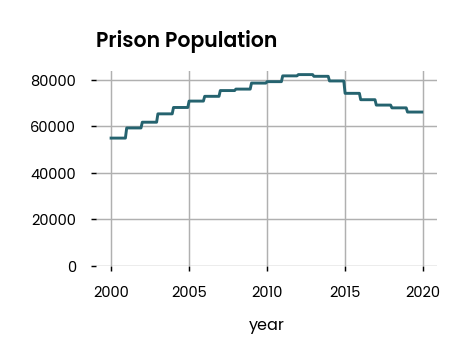

In [23]:
total_population.groupby("year").sum()["total_population"].plot()
plt.title("Prison Population")
plt.ylim([0, None])

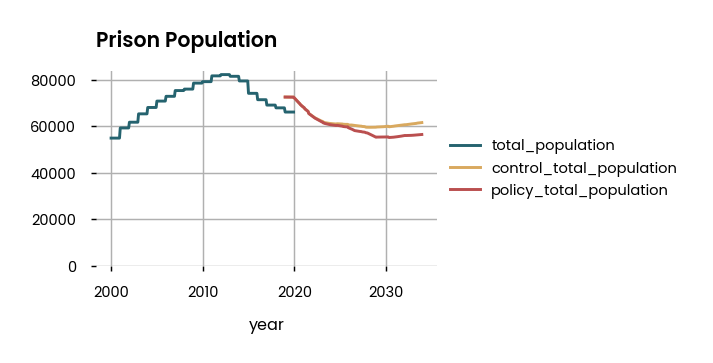

In [32]:
prison_simulation_results = test_results[test_results["compartment"].isin(["prison", "prison_return"])]

total_population.groupby("year").sum()["total_population"].plot()
prison_simulation_results.groupby(prison_simulation_results.index).sum()["control_total_population"].plot()
prison_simulation_results.groupby(prison_simulation_results.index).sum()["policy_total_population"].plot()
plt.title("Prison Population")
plt.ylim([0, None])
add_legend()


In [82]:
# Select the prison transitions from the input data
prison_transitions = test_sim.initializer.data_dict['transitions_data'][
    test_sim.initializer.data_dict['transitions_data'].compartment == 'prison'
]
policy_offense_types = ["841_5yr", "841_10yr", "841_15yr", "courier_960_5yr", 
                        "courier_960_10yr", "courier_960_15yr"]

In [85]:
# Extract the post-policy transition tables and un-normalize them
post_policy_transitions = pd.DataFrame()
for offense_type in policy_offense_types:
    policy_transition_table = test_sim.simulator.pop_simulations["policy"].sub_simulations[offense_type]\
        .simulation_compartments["prison"].compartment_transitions.transition_tables[24]
    transitions = policy_transition_table.unnormalize_table(TransitionTableType.AFTER)
    transitions["crime_type"] = offense_type
    transitions = transitions.reset_index(drop=False)
    transitions = transitions.rename({"release": "total_population"}, axis=1)
    post_policy_transitions = post_policy_transitions.append(transitions)

post_policy_transitions.head()

outflow_to,compartment_duration,total_population,crime_type
0,1,0.003413,841_5yr
1,2,0.004057,841_5yr
2,3,0.003515,841_5yr
3,4,0.000376,841_5yr
4,5,0.001245,841_5yr


In [94]:
# Compute the average length of stay pre-policy
def weighted_avg(group):
    return np.average(group.compartment_duration/12, weights=group.total_population)
prison_transitions.groupby("crime_type").apply(weighted_avg)

crime_type
841_10yr             8.005724
841_15yr            14.895231
841_5yr              5.610949
courier_960_10yr     3.421828
courier_960_15yr    13.924500
courier_960_5yr      2.656070
dtype: float64

In [95]:
# Compute the average length of stay post-policy
post_policy_transitions.groupby("crime_type").apply(weighted_avg)

crime_type
841_10yr             6.456139
841_15yr            13.625259
841_5yr              4.238395
courier_960_10yr     3.490099
courier_960_15yr    13.787273
courier_960_5yr      2.833515
dtype: float64

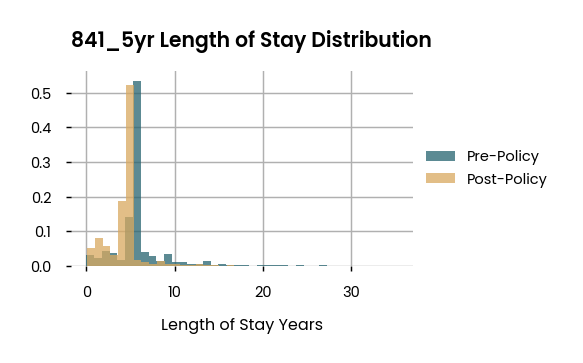

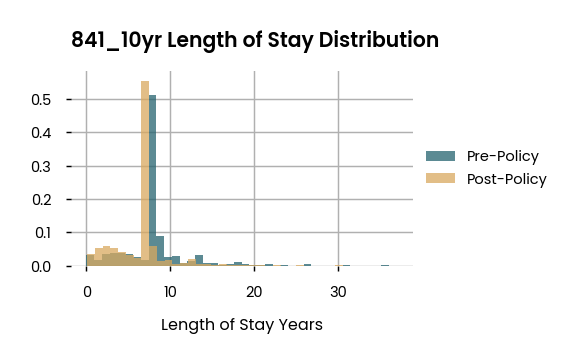

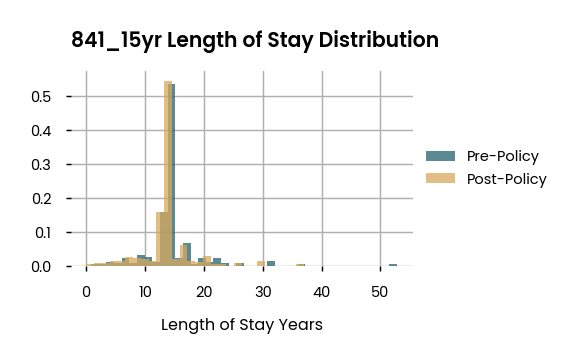

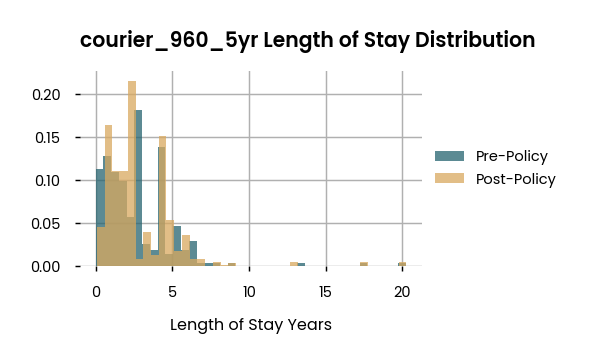

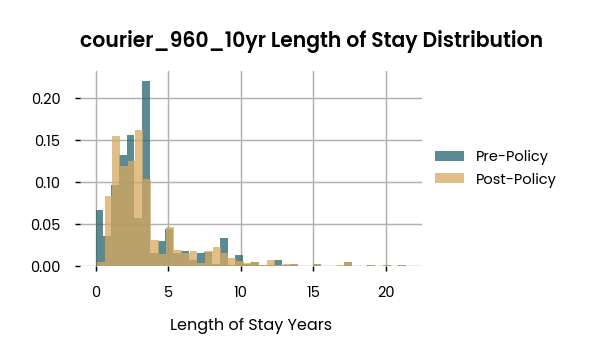

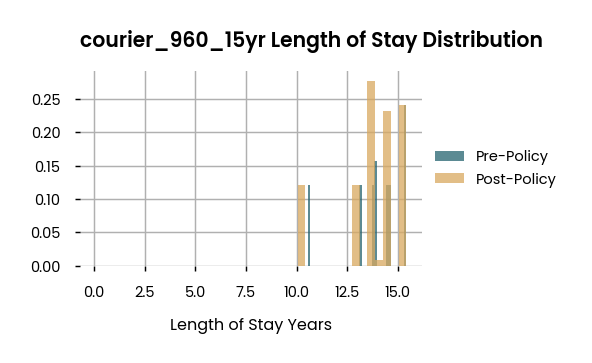

In [96]:
for offense_type in policy_offense_types:
    plt.figure()
    
    offense_type_transitions = prison_transitions[prison_transitions.crime_type == offense_type]
    total_population = sum(offense_type_transitions.total_population)
    plt.hist(offense_type_transitions.compartment_duration/12, 
             weights=offense_type_transitions.total_population/total_population, bins=40, alpha=0.75,
            label="Pre-Policy")
    
    after_policy_transitions = post_policy_transitions[post_policy_transitions["crime_type"] == offense_type]
    after_total = after_policy_transitions.total_population.sum()
    plt.hist(after_policy_transitions.compartment_duration/12, 
             weights=after_policy_transitions.total_population/after_total, bins=40, alpha=0.75,
            label="Post-Policy")    
    
    plt.title(f"{offense_type} Length of Stay Distribution")
    plt.xlabel("Length of Stay Years")
    add_legend()


In [48]:
transitions.head()

outflow_to,release
compartment_duration,
1,0.005745
2,0.000522
3,0.000440
4,0.001920
5,0.001714


7.287607741451501

(array([2.35775265e-02, 3.56550775e-02, 4.31089835e-02, 3.94919043e-02,
        3.11263678e-02, 2.46101841e-02, 1.84164752e-02, 5.25483818e-01,
        9.26152114e-02, 2.47914176e-02, 2.85458183e-02, 8.41712963e-03,
        1.51400216e-02, 3.35107768e-02, 7.02515291e-03, 9.09103112e-03,
        3.31488828e-03, 7.56264706e-03, 6.37410675e-03, 5.73774432e-03,
        8.47918029e-04, 1.13545923e-03, 5.90439073e-03, 0.00000000e+00,
        1.93028153e-03, 1.73994502e-04, 3.93735157e-04, 3.74701766e-03,
        0.00000000e+00, 0.00000000e+00, 1.13545996e-04, 2.27092151e-04,
        1.13545982e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.81275981e-04, 6.04487845e-05, 5.30972040e-05]),
 array([ 0.08333333,  1.00625   ,  1.92916667,  2.85208333,  3.775     ,
         4.69791667,  5.62083333,  6.54375   ,  7.46666667,  8.38958333,
         9.3125    , 10.23541667, 11.15833333, 12.08125   , 13.00416667,
        13.92708333, 14.85      , 15.77291667, 16.69583333,

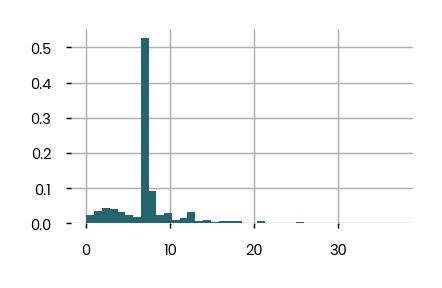

In [49]:
plt.hist(transitions.index/12, weights=transitions.release, bins=40)

In [57]:
transitions["release"]

compartment_duration
1      0.005745
2      0.000522
3      0.000440
4      0.001920
5      0.001714
         ...   
440    0.000000
441    0.000000
442    0.000000
443    0.000000
444    0.000000
Name: release, Length: 444, dtype: float64